# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1.Introduction <a name="introduction"></a>

__1.1 Scenario and Background:__
I am planning to start a food truck in city of Toronto and I wanted to know in which areas the food is being supplied by different media and more venues are there other than food supplies. In that type of area, I can move my food truck with in the that area to make more business with less efforts to find a place to do food business.

__1.2 Problem to be resolved:__
How to find a neighborhood in Toronto with the following conditions to move food truck

* Food business is successful
* More venues along with restaurants
* Area with radius of 1km

__1.3 Interested Audience:__
I believe the methodology, tools and strategy used in this project is relevant for a person or entity considering moving to a major city in US, Europe or Asia.  Europe, US or Asia, Likewise, it can be helpful approach to explore the opening of a new business. The use of FourSquare data and mapping techniques combined with data analysis will help resolve the key questions arisen. Lastly, this project is a good practical case for a person developing Data Science skills. 

## 2. Data <a name="data"></a>

__2.1 Data Requirements:__
* Data with postal codes and neighborhoods in the city of Toronto with latitude and longitude
* Nearby venues of the neighborhoods 

__2.2 Data Sources, Data Processing and Tools used:__
* Postal codes with neighborhoods will be web scrapped form wiki page using beautifulsoup
'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
* Latitude and longitude of the neighborhood will be collected from the following geospatial data http://cocl.us/Geospatial_data
* Nearby venues of the neighborhoods collected by using foursquare api.


importing required libraries

In [45]:
import pandas as pd # library for data analsysis
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import io
import requests # tohandle requests
#!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
#!pip install -U scikit-learn scipy matplotlib
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

__getting Postal codes with neighborhoods from wikipedia__

by doing web scraping ,using the BeautifulSoup package and creating a data frame with the data

<i> Beautiful Soup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping.</i>

In [4]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [5]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'html.parser')
My_table = soup.find('table',{'class':'wikitable sortable'})
headers="Postcode,Borough,Neighborhood"


You are using pip version 18.0, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
table1=""
for tr in My_table.find_all('tr'):
    row1=""
    for tds in tr.find_all('td'):
        if tds.text=="\n":
            row1=row1+"\t"+"Not assigned"
        else:
            row1=row1+"\t"+tds.text.rstrip()
    table1=table1+row1[1:]+"\n"
print(table1)


M1A	Not assigned	Not assigned
M2A	Not assigned	Not assigned
M3A	North York	Parkwoods
M4A	North York	Victoria Village
M5A	Downtown Toronto	Regent Park, Harbourfront
M6A	North York	Lawrence Manor, Lawrence Heights
M7A	Downtown Toronto	Queen's Park, Ontario Provincial Government
M8A	Not assigned	Not assigned
M9A	Etobicoke	Islington Avenue, Humber Valley Village
M1B	Scarborough	Malvern, Rouge
M2B	Not assigned	Not assigned
M3B	North York	Don Mills
M4B	East York	Parkview Hill, Woodbine Gardens
M5B	Downtown Toronto	Garden District, Ryerson
M6B	North York	Glencairn
M7B	Not assigned	Not assigned
M8B	Not assigned	Not assigned
M9B	Etobicoke	West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
M1C	Scarborough	Rouge Hill, Port Union, Highland Creek
M2C	Not assigned	Not assigned
M3C	North York	Don Mills
M4C	East York	Woodbine Heights
M5C	Downtown Toronto	St. James Town
M6C	York	Humewood-Cedarvale
M7C	Not assigned	Not assigned
M8C	Not assigned	Not assigned
M9C	Etobicoke	Eringate, B

In [7]:
df = pd.read_csv(io.StringIO(table1),header=None,sep="\t")
df.columns=["Postalcode","Borough","Neighborhood"]
print(df.shape)
df.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


__preprocessing the data set __

we remove the rows which contain not assigned as a value for borough or neighborhood usually this is refered as cleaning

In [8]:
df=df[df['Borough'] !="Not assigned"].reset_index(drop=True)
df.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


__collecting the geospatial data__

now we will collect the geospatial data for lattitude and longitude of the collected postal codes in city of toronto

In [10]:
df_ll = pd.read_csv("http://cocl.us/Geospatial_data")
df_ll.columns=['Postalcode','Latitude','Longitude']
df_ll.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


now we will combine both the data sets on postalcode

In [12]:
df= pd.merge(df,df_ll[['Postalcode','Latitude', 'Longitude']],on='Postalcode')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


__visualizing the toronto map__

finding the coordinateds of toronto city using geolocator and creating a map with our neighborhoods and lets see how areal view looks like

In [14]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [15]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

# add markers to map
for lat, lng, borough, Neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### foursquare
__nearby venues using foursquare api__

now we have to find the nearby venues of our neighborhoods using the foursquare api with latitude and longitude

<i>Foursquare City Guide, commonly known as Foursquare, is a local search-and-discovery mobile app developed by Foursquare Labs Inc. The app provides personalized recommendations of places to go near a user's current location based on users' previous browsing history and check-in history. </i>


In [16]:
CLIENT_ID = '5I1PML4N4OF2RYNZTCPXO21WRIPTPRH3DLKURQYB23MPKRAS' # your Foursquare ID
CLIENT_SECRET = 'CIOKRGR1Z4AKVB1OSEGY3CMYZT4UPX3T0BCRSZH2BC5B1A5N' # your Foursquare Secret
VERSION = '20200526' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5I1PML4N4OF2RYNZTCPXO21WRIPTPRH3DLKURQYB23MPKRAS
CLIENT_SECRET:CIOKRGR1Z4AKVB1OSEGY3CMYZT4UPX3T0BCRSZH2BC5B1A5N


In [17]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        try: 
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(url)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [20]:
print(toronto_venues.shape)
toronto_venues.head()

(2142, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


now we have the all the data regarding venues nearby the neighborhoods and their locations

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Food truck


## 3.Methodology<a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Toronto that the food is being supplied by different media and more venues are there other than food supplies. We will limit our analysis to area ~1km around city center.

In first step we have collected the required data: location and venues with in 500m radius in toronto city . We have also identified venue category (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of 'venue freaqunecies' across different areas of Toronto - 
we group the venues by their neighborhoods and finding most common venue type.

In third and final step we will focus on most promising areas and within those create clusters of locations that meet some basic requirements established: we will take into consideration locations with more number of venues and food as a most common one. We will present map of all such locations but also create clusters (using k-means clustering) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final borough exploration and search for optimal venue locations by stakeholders.

## 4.Analysis<a name="analysis"></a> 



lets see, for each neighborhood how many venues are there 

In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18


let us visualize the counts of each neighborhoods 

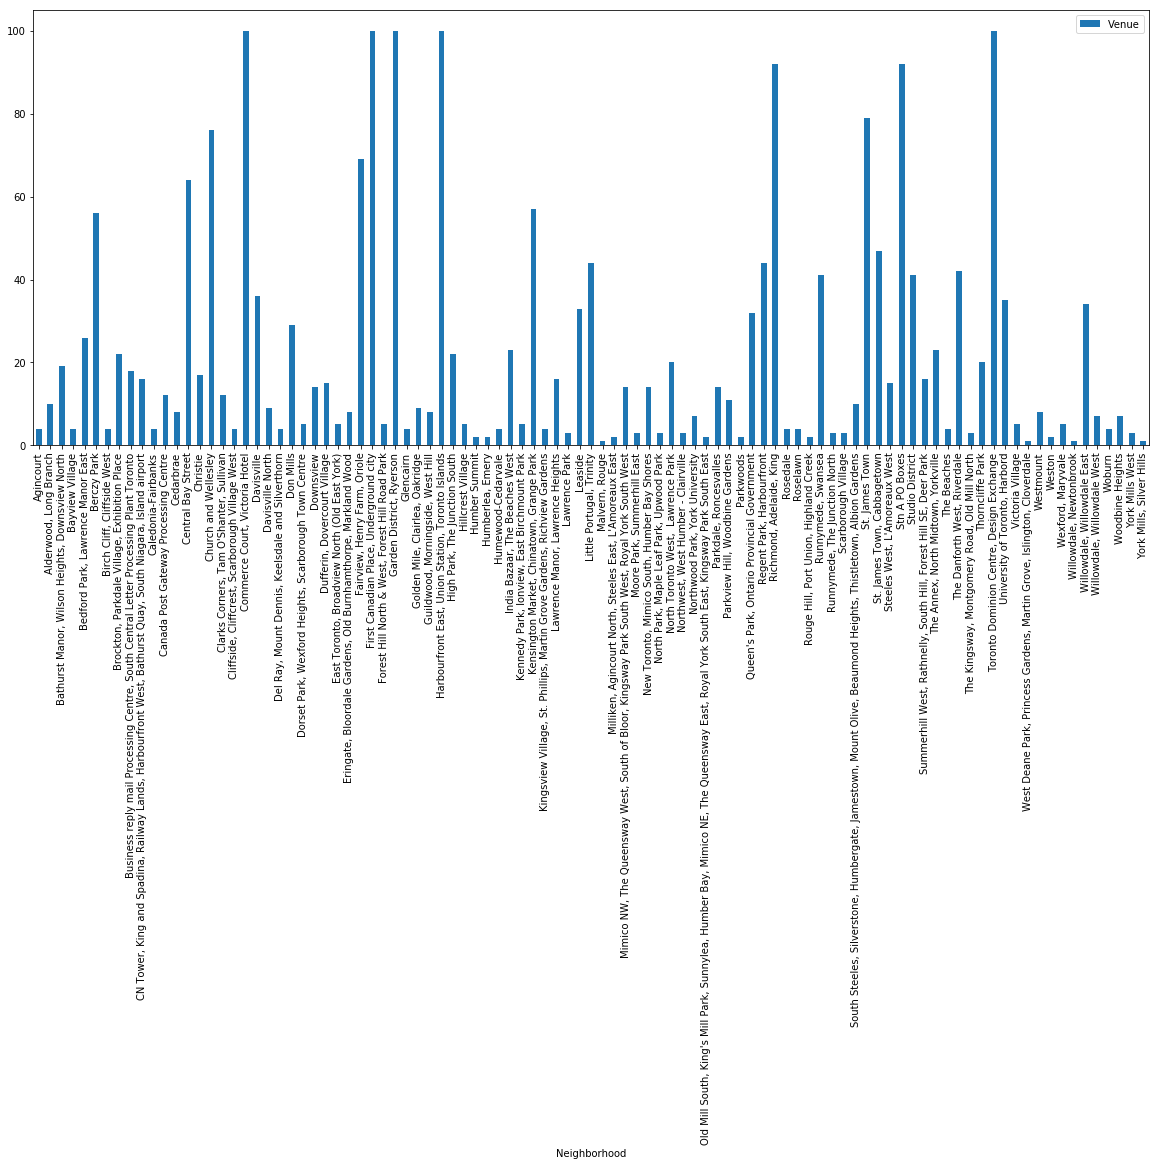

In [36]:

toronto_venues.groupby('Neighborhood').count()[['Venue']].plot(kind='bar',figsize=(20,8))
                                                                                   


now we can easily see which neighborhoods have more neaby venues.
lets find venue caterogies

In [39]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
print(pd.Series(toronto_venues['Venue Category'].unique()))

There are 273 uniques categories.
0                                 Park
1                    Food & Drink Shop
2                         Hockey Arena
3                          Coffee Shop
4                Portuguese Restaurant
5                    French Restaurant
6                         Intersection
7                               Bakery
8                       Breakfast Spot
9                  Distribution Center
10                                 Spa
11                          Restaurant
12                Gym / Fitness Center
13                       Historic Site
14                      Farmers Market
15                      Chocolate Shop
16                                 Pub
17               Performing Arts Venue
18                        Dessert Shop
19                         Yoga Studio
20                                Café
21                             Theater
22                         Event Space
23                      Ice Cream Shop
24                          Sh

__ start analysing each neighborhood__

lets find the onehost encoding of the neighborhoods with venue category for clustering purpose


In [40]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

lets group all these with neighborhood

we can see the proportions of neighborhoods to venue category

In [41]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0000,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,

lets print what are the top5 venues categories in each neighborhood along eith frequency

In [42]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2               Skating Rink  0.25
3  Latin American Restaurant  0.25
4                Men's Store  0.00


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place   0.2
1                Pool   0.1
2      Sandwich Place   0.1
3  Athletics & Sports   0.1
4                 Pub   0.1


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0            Bank  0.11
1     Coffee Shop  0.11
2     Pizza Place  0.05
3  Ice Cream Shop  0.05
4   Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2          Restaurant  0.08
3    Sushi Re

               venue  freq
0        Pizza Place  0.25
1               Park  0.25
2     Sandwich Place  0.25
3           Bus Line  0.25
4  Accessories Store  0.00


----Lawrence Manor, Lawrence Heights----
                    venue  freq
0          Clothing Store  0.25
1  Furniture / Home Store  0.19
2           Women's Store  0.12
3       Accessories Store  0.06
4             Coffee Shop  0.06


----Lawrence Park----
               venue  freq
0               Park  0.33
1        Swim School  0.33
2           Bus Line  0.33
3  Accessories Store  0.00
4      Metro Station  0.00


----Leaside----
                    venue  freq
0     Sporting Goods Shop  0.09
1             Coffee Shop  0.09
2            Burger Joint  0.06
3                    Bank  0.06
4  Furniture / Home Store  0.06


----Little Portugal, Trinity----
              venue  freq
0               Bar  0.09
1  Asian Restaurant  0.07
2        Restaurant  0.07
3       Coffee Shop  0.05
4       Men's Store  0.05


----Malvern, R

                   venue  freq
0         Breakfast Spot   0.2
1  Vietnamese Restaurant   0.2
2            Auto Garage   0.2
3         Sandwich Place   0.2
4                 Bakery   0.2


----Willowdale, Newtonbrook----
                             venue  freq
0                        Piano Bar   1.0
1                      Men's Store   0.0
2  Molecular Gastronomy Restaurant   0.0
3       Modern European Restaurant   0.0
4               Miscellaneous Shop   0.0


----Willowdale, Willowdale East----
              venue  freq
0  Ramen Restaurant  0.09
1       Pizza Place  0.06
2       Coffee Shop  0.06
3    Sandwich Place  0.06
4  Sushi Restaurant  0.06


----Willowdale, Willowdale West----
           venue  freq
0    Pizza Place  0.14
1       Pharmacy  0.14
2           Bank  0.14
3  Grocery Store  0.14
4        Butcher  0.14


----Woburn----
                             venue  freq
0                      Coffee Shop  0.50
1                Korean Restaurant  0.25
2                Indian 

a function to return most common venues in the neighborhood

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pub,Pool,Gym,Coffee Shop,Skating Rink,Pharmacy,Athletics & Sports,Sandwich Place,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sushi Restaurant,Pizza Place,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Ice Cream Shop
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sushi Restaurant,Restaurant,Sandwich Place,Italian Restaurant,Pharmacy,Pizza Place,Cupcake Shop,Pub,Café


by doing this we ca easly see what are the top 10 common venues in each 

lets visualize the most common venue using wordcloud

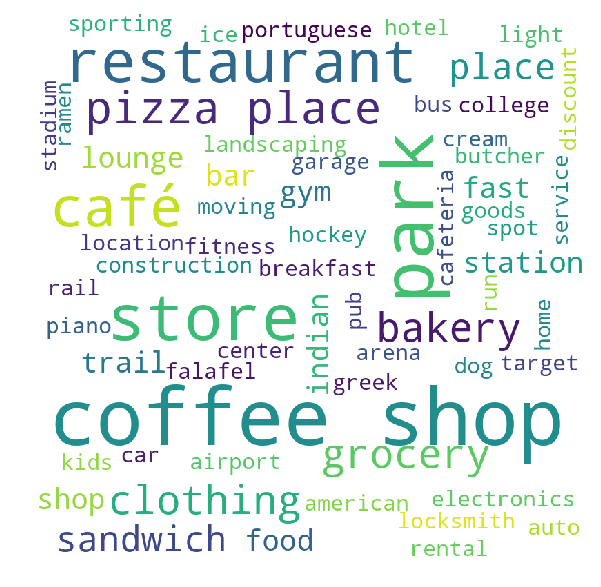

In [65]:
from wordcloud import WordCloud
comment_words=""
for val in neighborhoods_venues_sorted['1st Most Common Venue']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


## clusetring the neighbors
**cluster the items using Kmeans**


<i>k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster</i>

let us devide the neighbors as 4 parts based on the venues

In [66]:
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 0, 0, 0, 0, 0, 0, 0])

lets add the cluster laber to the neighborhood 

In [67]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(axis=0,inplace=True)
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype('int64')
toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Intersection,Coffee Shop,French Restaurant,Hockey Arena,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Yoga Studio,Farmers Market,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Women's Store,Accessories Store,Boutique,Sporting Goods Shop,Miscellaneous Shop,Event Space,Vietnamese Restaurant,Coffee Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Italian Restaurant,Diner,Bar,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Mexican Restaurant


now visualize the clusters on the map and then we will select the appropriate clusters based on our requirements

In [68]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### analysing clusters

lets find out how many venues are there in each cluster and what are the venue categories in each cluster

__ cluster 1__

In [77]:
c0=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('total number of neighborhood in this clusters is',c0.shape[0])
c0_n=c0.shape[0]
print("most common venue in this cluster are")
print(pd.Series(c0['1st Most Common Venue'].unique()))

total number of neighborhood in this clusters is 83
most common venue in this cluster are
0          Portuguese Restaurant
1                    Coffee Shop
2                 Clothing Store
3                            Gym
4                         Bakery
5                   Home Service
6                  Moving Target
7                           Park
8                   Hockey Arena
9                           Café
10             Electronics Store
11                         Trail
12           Sporting Goods Shop
13                 Grocery Store
14                       Dog Run
15             Indian Restaurant
16            Falafel Restaurant
17                           Bar
18                   Bus Station
19              Greek Restaurant
20                     Cafeteria
21                Sandwich Place
22           American Restaurant
23                Discount Store
24    Construction & Landscaping
25               College Stadium
26              Ramen Restaurant
27                I

__cluster 2__

In [79]:
c1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('total number of neighborhood in this clusters is',c1.shape[0])
c1_n=c1.shape[0]
print("most common venue in this cluster are")
print(pd.Series(c1['1st Most Common Venue'].unique()))

total number of neighborhood in this clusters is 1
most common venue in this cluster are
0    Piano Bar
dtype: object


__cluster 3__

In [80]:
c2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('total number of neighborhood in this clusters is',c2.shape[0])
c2_n=c2.shape[0]
print("most common venue in this cluster are")
print(pd.Series(c2['1st Most Common Venue'].unique()))

total number of neighborhood in this clusters is 10
most common venue in this cluster are
0    Park
dtype: object


__ cluster 4__

In [81]:
c3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('total number of neighborhood in this clusters is',c3.shape[0])
c3_n=c3.shape[0]
print("most common venue in this cluster are")
print(pd.Series(c3['1st Most Common Venue'].unique()))

total number of neighborhood in this clusters is 7
most common venue in this cluster are
0    Fast Food Restaurant
1             Pizza Place
2                    Park
dtype: object


visualize clusters with number of nieghbors

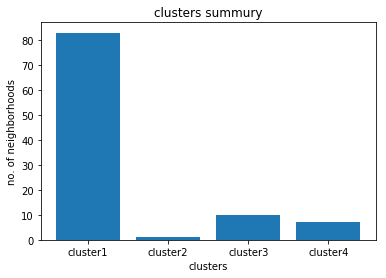

In [87]:
plt.bar(['cluster1','cluster2','cluster3','cluster4'],[c0_n,c1_n,c2_n,c3_n])
plt.title('clusters summary')
plt.xlabel('clusters')
plt.ylabel('no. of neighborhoods')
plt.show()

by seeing this graph we can easlily say that we have to select the cluster 1 

__clusters and most common venue__

In [91]:
print("**cluster-> Most Common Venue")
print('cluster 1->',c0['1st Most Common Venue'].unique()[0])
print('cluster 2->',c1['1st Most Common Venue'].unique()[0])
print('cluster 3->',c2['1st Most Common Venue'].unique()[0])
print('cluster 4->',c3['1st Most Common Venue'].unique()[0])

**cluster-> Most Common Venue
cluster 1-> Portuguese Restaurant
cluster 2-> Piano Bar
cluster 3-> Park
cluster 4-> Fast Food Restaurant


__ list of places to move the truck__

lets see the list of  borough from the cluster 1

In [95]:
print('total number of places to move the truck is ',len(c0['Borough'].unique()))
print('here, is the list of places to move the food truck: ')
print(pd.Series(c0['Borough'].unique()))

total number of places to move the truck is  10
here, is the list of places to move the food truck: 
0          North York
1    Downtown Toronto
2           Etobicoke
3         Scarborough
4           East York
5                York
6        East Toronto
7        West Toronto
8     Central Toronto
9         Mississauga
dtype: object


## 5.Results and Discussion<a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Toronto, there are pockets of food truck in city center. Highest concentration of venues was detected in 10 places in a cluster which includes North York,Downtown Toronto,   Etobicoke,Scarborough,East York,York,East Toronto,West Toronto,Central Toronto,Mississauga which satisifies our conditions.

firstly we concentrated on the nieghborhoods groups and calculated the frequent venues in each neighborhoods and got to know food is common so we decided that food has priority. after this we formed 4 clusters suing kmeans algorithm and found each cluster with its particulars.

among those 4 we have one cluster with more number of venues so people will roam around that places so we can have a food truck in that particluar places to make good money.
we can do further by tracking the trending places and to move the truck accordingly. 

## 6.Conclusion <a name="conclusion"></a>

our main goal is to find a neighborhood in Toronto where
Food business is successful and
More venues along with restaurants

now we got 10 places where there are more number of venues as you can see in maps with limited radius and food is being most common so we can choose those plcaes to move the food truck